# Analyzing Race Results Part 2: Analyzing and Plotting Data

In my previous post, I used the ```BeautifulSoup``` Python library to scrape HTML data from the web, clean it, and read it into ```Pandas```. The data that I use are the [2015](http://www.empirerunners.com/results/empireopen/eo15.html) and [2016](http://www.empirerunners.com/results/empireopen/eo16.html) results from the Empire Open Cross Country Meet - a 3.43 mile race that my running club hosts every year in Santa Rosa. 

Now I have a cleaned dataset of 2 years of race results parsed from HTML. In this post I will actually analyze this data a bit and generate some interesting stats and plots. I'll use the grouping operations in ```Pandas``` to compare team performances across years; ```Matplotlib``` and its wrapper ```seaborn``` to make plots that visualize these comparisons; and ```Statsmodels``` to build a basic regression model that can be used to control for age and gender when comparing times. 

In [29]:
#Import necessary Python modules

import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.cm import get_cmap
import numpy as np
%matplotlib inline

First I read in the cleaned dataframe that I generated in the last post and saved as a Pickle file (this is just an efficient way to save a Python object to disk and then read it back in).

This data contains 547 race finish times across 2 years of the same race. I have the data sorted by finish time across both years. As you can see, from the first 5 rows printed below, the same runner placed 2nd in both 2015 and 2016. The data includes the information we would expect to see in race results - Place, Name, Team, Age, Gender, Time, etc.

In [30]:
df = pd.read_pickle('cleaned_race_results.p')
print df.shape
print df.head()

(547, 12)
   Place              Name                    Team  Bib No  Age Gender  \
0      1      Isaac Chavez     Aggies Running Club     414   24      M   
1      2  Malcolm Richards  West Valley Track Club     306   32      M   
2      1    Trevor Halsted              UNATTACHED     701   23      M   
3      2  Malcolm Richards  West Valley Track Club     623   33      M   
4      3  Alfonso Cisneros     Aggies Running Club     413   23      M   

    Age Group Total Time    Pace  Year     Time    Minutes  
0  1/52 16-99      16:51  4:54/M  2015 00:16:51  16.850000  
1  2/52 16-99      16:56  4:56/M  2015 00:16:56  16.933333  
2     1 16-99      16:56  4:56/M  2016 00:16:56  16.933333  
3     2 16-99      17:05  4:59/M  2016 00:17:05  17.083333  
4  3/52 16-99      17:07  4:59/M  2015 00:17:07  17.116667  


## Get Average Time Team Rankings by Gender and Year
A useful piece of information would be to compare teams by gender and year to see which teams are the fastest. In cross-country races the fastest team is determined by the *place* of its top 5 runners. However, I am instead going to look at the *average time* of the top 5 runners, which will provide more useful comparisons across years. 

The first step here is to identify the top 5 runners on each team for each year and gender. Not all teams had a "full-team" of 5 runners so the first step is to identify which runners are on full-teams. Then I subset the top 5 runners from each of these full teams. This is easy to do by applying functions to ```Pandas``` groupby objects, which I do below. 

I can also easily determine the number of full-teams by gender and year, which I print out below. In 2015 there were 7 full women's teams and 11 full men's teams, and in 2016 there were 8 of each.

In [31]:
#define columns that will be used to aggregate by
group_cols = ['Team','Gender','Year']

#find out which runners are on a full team (at least 5 people and not "unattached")
full_team = (df.groupby(group_cols)['Name'].transform('size')>=5) & (df.Team<>'UNATTACHED')

#get the team, year, gender, and time of those top 5 runners on full teams 
top5 = df[full_team].groupby(group_cols)['Minutes'].nsmallest(5).reset_index()[['Team', 'Gender','Year','Minutes']]

#determine number of complete teams in each year
print top5.groupby(['Gender','Year'])['Team'].apply(lambda x:len(x.unique())).unstack()

Year    2015  2016
Gender            
F          7     8
M         11     8


Now that I have subsetted the top 5 runners in each full-team, I can calculate the average time for each of those teams. I do that below using the ```Pandas``` cross-tab function, specifying that I want the data tabulated by Team, Year, and Gender, while calculating the mean time.

The result is a dataframe indexed by each unique team, with columns for the average time of that team by year and gender. There are some cases where a team only has runners of one gender or only ran one year; and in these cases the team has a null value.

In [32]:
#use crosstab function and aggregate times by taking the mean
avg_times = pd.crosstab(top5.Team, [top5.Gender, top5.Year], values = top5.Minutes, aggfunc=lambda x:round(x.mean(),2))
print avg_times.sort_index()

Gender                                 F             M       
Year                                2015   2016   2015   2016
Team                                                         
Aggies Running Club                  NaN    NaN  17.63    NaN
Buffalo Chips                        NaN  27.02  29.11  25.47
Empire Runners Club                23.46  23.06  19.76  19.27
Excelsior Running Club               NaN    NaN  18.99  20.01
Golden Valley Harriers             22.90  24.38  20.66  19.75
Humboldt Track Club                  NaN    NaN  22.07    NaN
Impala Racing Team                 21.86  21.68    NaN    NaN
Lake Merritt Joggers and Striders  26.15  26.05    NaN    NaN
Pamakids                           23.33  24.41  21.20  22.66
Strawberry Canyon TC               21.06  22.27  18.13  17.94
Tamalpa Runners                    23.56  28.03  20.77  21.25
West Valley Joggers & Striders       NaN    NaN  19.85    NaN
West Valley Track Club               NaN    NaN  17.85  17.62


Then from my dataframe of average times, I can calculate the team rankings by age and gender. Note that I first exclude teams with null values (because they didn't have a team for a gender or year), so that these teams do not appear in the listings.

I show the top 3 teams for each year and gender by average time below.

In [33]:
team_rankings = avg_times.apply(lambda x: x.index.where(x.notnull(), '')[x.values.argsort()]).reset_index(drop=True)
team_rankings.index = team_rankings.index+1
team_rankings.columns.names=[None, None]
print team_rankings[:3]

                        F                                             M  \
                     2015                  2016                    2015   
1    Strawberry Canyon TC    Impala Racing Team     Aggies Running Club   
2      Impala Racing Team  Strawberry Canyon TC  West Valley Track Club   
3  Golden Valley Harriers   Empire Runners Club    Strawberry Canyon TC   

                           
                     2016  
1  West Valley Track Club  
2    Strawberry Canyon TC  
3     Empire Runners Club  


## Comparing Team Performances Across Years
Next, I will look among teams that competed both in 2015 and 2016 and compare their results to see which teams got faster and which teams got slower. Below, I calculate the number of seconds faster that each team ran in 2016. Below I identify that the Tamalpa Runners Women's team improved the most, with a top 5 runner average 268 seconds faster (almost 4.5 minutes!) in 2016 than 2016.

In [34]:
team_time_compare = avg_times.stack(level=0).dropna()
seconds_faster = (team_time_compare[2016] - team_time_compare[2015]).sort_values(ascending=False)*60
print seconds_faster.idxmax(), seconds_faster.max()

(u'Tamalpa Runners', u'F') 268.2


Most other teams did not improve quite as much. About half of the teams that ran both years ran faster, and about half ran slower.

In [35]:
print "{} teams ran faster and {} teams ran slower".format((seconds_faster>0).sum(), (seconds_faster<0).sum())
print "Team average time improved by an average of {} seconds in 2016".format(int(seconds_faster.mean()))

7 teams ran faster and 8 teams ran slower
Team average time improved by an average of 20 seconds in 2016


To help visualize these team comparisons, I make a bar plot of team average time differences. Additionally, I use a Blue-to-Red colormap to visualize the amount faster or slower that each team ran. This is all pretty easy to do using ```Matplotlib``` along with the built in plotting functions in ```Pandas```.

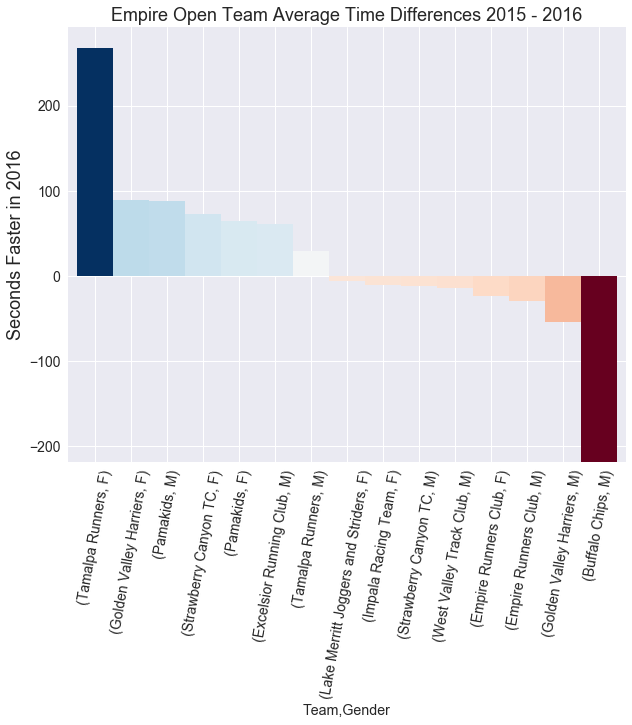

In [36]:
#define colormap
cmap = get_cmap('RdBu')

#normalize data 0-1 to get each teams color within the color map
norm_data = (seconds_faster-seconds_faster.min())/(seconds_faster.max()-seconds_faster.min())
colors = [cmap(pct) for pct in norm_data]

#define figure and axis
fig, ax = plt.subplots(figsize=(10,8))   
#use pandas buit in plotting features to plot to this axis
seconds_faster.plot(kind='bar', ax=ax, fontsize=14, color=colors, width=1, rot=80)

#Set title and labels
ax.set_title('Empire Open Team Average Time Differences 2015 - 2016',fontsize=18)
ax.set_ylabel('Seconds Faster in 2016', fontsize=18)


## Model Effect of Age and Gender on Race Time

The last thing I would like to do is use this data to visualize and quantify the effect that age and gender have on race times. Using the ```lmplot``` method in ```seaborn``` I can easily visualize the relationship between age, gender, and time in 1 plot for both years. I use different colors to identify male vs female, and then plot age against time, specifying that I want each year in a separate plot. 

As we might expect to see, in general, times get slower as age increases, but this relationship is not linear. In the younger age groups, people run faster as they get older, but after 30 or so, people start running slower. This same general pattern holds in both years and for both men and women. 

The ```lmplot``` method also fits a linear regression model and plots the line along with its confidence interval. Given the fact that the relationship between age and gender has a curve to it, I fit the model with a 2nd order polynomial, which fits the curvilinear relationship.


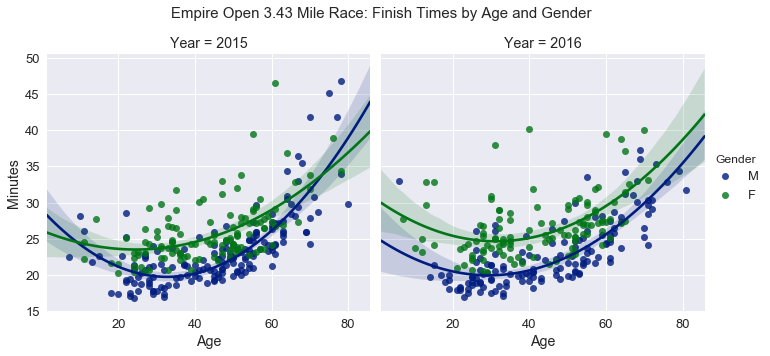

In [37]:
g=sns.lmplot('Age', 'Minutes', data=df, hue='Gender', order=2, palette='dark', col='Year')
t=plt.suptitle('Empire Open 3.43 Mile Race: Finish Times by Age and Gender', size=15)
g.fig.subplots_adjust(top=.85)

While ```seaborn``` will fit and plot a regression line, you can't actually obtain the results of that regression. For this I use ```statsmodels```, a statistics module that has a formula framework similar to ```R``` and also interfaces really nicely with ```Pandas```. 

Below I fit a basic OLS regression model that replicates the model used by ```seaborn``` to generate the regression lines plotted above. I regress race minutes against age, age-squared, gender, and year. I include both age and age-squared in the model to take into account the 2nd order polynomial fit. I also specify that I want to treat gender and year as categorical variables (```Statsmodels``` automatically chooses the excluded group for categorical variables). 


In [38]:
import statsmodels.formula.api as smf
model = smf.ols(formula = 'Minutes ~ Age + I(Age**2) + C(Gender) + C(Year)', data = df).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                Minutes   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     172.4
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           3.69e-95
Time:                        22:02:07   Log-Likelihood:                -1408.5
No. Observations:                 547   AIC:                             2827.
Df Residuals:                     542   BIC:                             2848.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          30.3114      0.970     

The coefficients of the terms in this model behave as we would expect given the plots above. The coefficient for male is negative and significant because in general times for men are faster than for women. The coefficient for year is not well-supported meaning there is no significant difference in times between the two years. The age effect also makes sense although is a bit more complicated to interpret because we include both age and age-squared to measure the curvilinear relationship. The negative age coefficient means that in general as age increases the number of minutes it takes to complete the race decreases (people get faster as they get older), but the positive squared term means that this effect decreases at higher ages (people start getting slower). Therefore the relationship between age and time is a u-shape. 

With ```statsmodels``` I can use the ```predict``` method to get expected values given defined inputs. Below I show that the predicted time of a 26-year-old male in 2015 was 20.12. I then print out my time in that year and see that I beat my predicted time by 1.4 minutes! (although, I fear that my time would be much less stellar if I had used one of the traditionally more competitive meets to build this model).

In [39]:
p = model.predict({'Age':26, 'Gender':'M', 'Year':2015})[0]
print "Predicted time (in minutes) of a 26 year old male in 2015: {}".format(round(p,2))

Predicted time (in minutes) of a 26 year old male in 2015: 20.12


In [40]:
print df.loc[(df.Name=='Andrew Gaidus')&(df.Year==2015), 'Minutes'].iloc[0]

18.75


Comparing the predicted value versus the actual value (as I just did for myself above) in a sense gives an indication of how well someone ran, controlling for their age and gender. The difference in predicted values vs actual values is simply the model residuals, and these can easily be obtained from the model. Below I use observations in 2016 with the most negative residuals to identify the top performances controlling for age and gender (according to my very simple model).

According to this ranking the top performance in 2016 was by a 71 year-old man who ran his race at 7:02 mile pace! This definitely sounds impressive to me.

In [41]:
#Get model residuals 
res=pd.Series(model.resid,name='Residuals')

#Top 5 performances controlling for age and gender
best_performances = df.join(res).sort_values(by='Residuals')

print 'Top 3 performances controlling for age and gender'
print best_performances[best_performances.Year==2016][['Name', 'Age', 'Gender', 'Time', 'Pace']][:3]


Top 3 performances controlling for age and gender
            Name  Age Gender     Time    Pace
286  Len Goldman   71      M 00:24:08  7:02/M
504  Bill Dodson   81      M 00:31:49  9:16/M
349  Gene French   70      M 00:25:13  7:21/M


And lastly, I will now generate team rankings in 2016 controlling for age and gender, by using the residuals of the top 5 runners of each team. 

In [42]:
top5_resid = df[full_team].join(res).groupby(['Team','Gender','Year'])['Residuals'].nsmallest(5).reset_index()
best_teams = top5_resid.groupby(['Team','Gender','Year'])['Residuals'].sum().unstack()[2016].sort_values()
print best_teams[:3]

Team                    Gender
Tamalpa Runners         M        -21.456713
Impala Racing Team      F        -19.757007
West Valley Track Club  M        -14.611984
Name: 2016, dtype: float64


As you can see, the Tamalpa Runners Men's team has the most negative sum of residuals. If we look at the age and times of these runners we see that they are indeed very impressive. The average age of their top 5 was 46 years old and the average pace is 5:56 per mile!

In [43]:
df16=df[df.Year==2016]
top_team =  df.set_index(['Team','Gender']).loc[best_teams.idxmin()].reset_index()[:5][['Age','Gender','Time', 'Pace']]
print top_team

   Age Gender     Time    Pace
0   38      M 00:20:03  5:50/M
1   47      M 00:20:20  5:55/M
2   52      M 00:20:22  5:56/M
3   51      M 00:20:23  5:56/M
4   44      M 00:20:44  6:02/M


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app
